# Rede Neural Recorrente simples para classificar dígitos MNIST

Este experimento ilustra o uso de uma rede neural recorrente na tarefa de classificação
de dígitos manuscritos do dataset MNIST.

A imagem é estruturada em 28 sequências de 28 pixels cada. Cada elemento da sequência é
formado por uma linha da imagem. Cada linha da imagem contém 28 atributos (pixels).

<img src='../figures/RNN_MNIST.png', width= 700></img>

**Obs:** Este experimento foi inspirado no artigo:
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf

A principal modificação é a formatação da imagem em 28 sequências de 28 pixels.

## Importação

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
from   torch.autograd import Variable

import torchvision

import lib.pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do dataset

In [2]:
dataset_dir = '/data/datasets/MNIST/'

data_train, target_train = torch.load(dataset_dir + 'processed/training.pt')
data_test,  target_test  = torch.load(dataset_dir + 'processed/test.pt')

data_train = data_train.float() / 255.
data_test  = data_test.float() / 255.

## Pouquíssimas amostras - depurando apenas

Para facilitar a depuração e rápida execução de testes, é importante treinar com
poucas amostras. Entretanto, quando o modelo precisar de fato ser treinado, é
preciso utilizar todas as amostras.
Na célula abaixo, controle o uso ou não de poucas amostras trocando o `True/False` do `if`:

In [3]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500
else:
    n_samples_train = data_train.size(0)
    n_samples_test  = data_test.size(0)
    
x_train = data_train[:n_samples_train].clone()
y_train = target_train[:n_samples_train].clone()
x_test  = data_test[:n_samples_test].clone()
y_test  = target_test[:n_samples_test].clone()
del data_train, target_train, data_test, target_test

In [4]:
x_train.shape

torch.Size([1000, 28, 28])

## SimpleRNN com 100 neurônios

In [5]:
class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(28, hidden_size, 1, 
                          batch_first=True, 
                          nonlinearity='relu', 
                          dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,x = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    

model_rnn = Model_RNN(100)
if use_gpu:
    model_rnn = model_rnn.cuda()
model_rnn

Model_RNN (
  (rnn): RNN(28, 100, batch_first=True, dropout=0.05)
  (out): Linear (100 -> 10)
)

## Predict com uma amostra

In [6]:
xin = x_train[0:2]
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_rnn(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([2, 28, 28])
Variable containing:
1.00000e-02 *
 -9.3403  4.7920 -2.5518 -4.2528  8.9308 -3.2487  0.7087 -5.6518 -8.3531  2.1443
 -9.1762  4.9318 -2.6070 -4.5537  8.8459 -3.3931  1.0606 -5.7942 -8.3147  1.8876
[torch.FloatTensor of size 2x10]



## Criando o treinador

In [7]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_rnn', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model_rnn,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.Adam(model_rnn.parameters(),lr=1e-3),
                        callbacks = [ptt.AccuracyMetric(),
                                     ptt.PrintCallback(),
                                     chkpt_cb]
                        )

### Treinando ou carregando modelo pré treinado

In [8]:
if False:
    trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)
else:
    trainer.load_state('/data/models/SimpleRNN_MNIST_rnn')

### Resultado quando foi treinado em GPU:

        Start training for 20 epochs
          1:   6.4s   T: 0.71404 0.75580   V: 0.28260 0.91540 best
          2:   6.5s   T: 0.28147 0.91710   V: 0.19563 0.94540 best
          3:   6.3s   T: 0.20546 0.94018   V: 0.19529 0.94650 best
          4:   6.4s   T: 0.18091 0.94835   V: 0.12322 0.96560 best
          5:   6.7s   T: 0.16066 0.95412   V: 0.18050 0.94920 
          6:   6.4s   T: 0.14633 0.95803   V: 0.12754 0.96220 
          7:   6.4s   T: 0.13626 0.96088   V: 0.14361 0.96070 
          8:   6.5s   T: 0.12443 0.96495   V: 0.10138 0.96990 best
          9:   6.4s   T: 0.11747 0.96702   V: 0.09719 0.97200 best
         10:   6.5s   T: 0.11033 0.96883   V: 0.12866 0.96400 
         11:   6.6s   T: 0.10589 0.97027   V: 0.12193 0.96640 
         12:   6.3s   T: 0.10110 0.97183   V: 0.09986 0.97100 
         13:   6.5s   T: 0.09670 0.97312   V: 0.09970 0.97310 
         14:   6.5s   T: 0.09486 0.97372   V: 0.09300 0.97470 best
         15:   6.3s   T: 0.09202 0.97380   V: 0.08467 0.97590 best
         16:   6.5s   T: 0.09106 0.97435   V: 0.09000 0.97590 
         17:   6.4s   T: 0.08923 0.97462   V: 0.10739 0.97060 
         18:   6.2s   T: 0.08400 0.97615   V: 0.08674 0.97770 
         19:   6.5s   T: 0.08492 0.97612   V: 0.10110 0.97250 
         20:   6.6s   T: 0.08428 0.97575   V: 0.09164 0.97590 
        Stop training at epoch: 20/20
        Best model was saved at epoch 15 with loss 0.08467: ../../models/SimpleRNN_MNIST_rnn

Acc: 0.9759


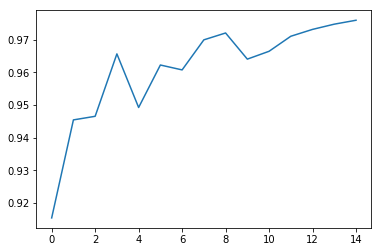

In [9]:
print('Acc:', trainer.metrics['valid']['acc'][-1])
plt.plot(trainer.metrics['valid']['acc']);

## Usando LSTM

In [10]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
model_lstm = Model_LSTM(100)
if use_gpu:
    model_lstm = model_lstm.cuda()

### Predict com uma amostra

In [11]:
xin = x_train[0:2]
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
if use_gpu:
    xv_in = xv_in.cuda()
ypred = model_lstm(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([2, 28, 28])
Variable containing:
 0.0438 -0.0425 -0.0667 -0.0108 -0.0171 -0.0542  0.0436  0.0327 -0.0910  0.1203
 0.0446 -0.0402 -0.0695 -0.0125 -0.0189 -0.0543  0.0421  0.0369 -0.0966  0.1246
[torch.FloatTensor of size 2x10]



### Criando o treinador

In [12]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_lstm', reset=True, verbose=1)

trainer_lstm = ptt.DeepNetTrainer(
                model_lstm,
                criterion = nn.CrossEntropyLoss(),
                optimizer = torch.optim.Adam(model_lstm.parameters(),lr=1e-3),
                callbacks = [ptt.AccuracyMetric(),
                             ptt.PrintCallback(),
                             chkpt_cb]
                )

### Treinando ou criando modelo pré treinado

In [13]:
if False:
    trainer_lstm.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)
else:
    trainer_lstm.load_state('/data/models/SimpleRNN_MNIST_lstm')

- Resultado do treinamento na GPU:
        Start training for 20 epochs
          1:   7.9s   T: 0.44033 0.86317   V: 0.16067 0.95540 best
          2:   7.7s   T: 0.14068 0.95862   V: 0.11364 0.96690 best
          3:   8.0s   T: 0.09463 0.97182   V: 0.08013 0.97440 best
          4:   7.7s   T: 0.07338 0.97805   V: 0.08376 0.97550 
          5:   7.9s   T: 0.06093 0.98127   V: 0.07614 0.97670 best
          6:   7.9s   T: 0.04963 0.98460   V: 0.05543 0.98240 best
          7:   7.7s   T: 0.04467 0.98662   V: 0.06603 0.98020 
          8:   7.9s   T: 0.03965 0.98748   V: 0.05926 0.98200 
          9:   7.7s   T: 0.03368 0.98980   V: 0.05323 0.98460 best
         10:   7.9s   T: 0.03080 0.99008   V: 0.05112 0.98530 best
         11:   7.9s   T: 0.02793 0.99142   V: 0.04420 0.98740 best
         12:   7.6s   T: 0.02403 0.99257   V: 0.05742 0.98420 
         13:   7.9s   T: 0.02233 0.99298   V: 0.05009 0.98580 
         14:   7.8s   T: 0.02128 0.99313   V: 0.04611 0.98780 
         15:   7.8s   T: 0.01861 0.99402   V: 0.04507 0.98760 
         16:   8.0s   T: 0.01692 0.99490   V: 0.05036 0.98600 
         17:   7.7s   T: 0.01715 0.99480   V: 0.05005 0.98720 
         18:   7.9s   T: 0.01322 0.99592   V: 0.07054 0.98320 
         19:   7.8s   T: 0.01438 0.99553   V: 0.04601 0.98840 
         20:   7.7s   T: 0.01321 0.99597   V: 0.04621 0.98790 
        Stop training at epoch: 20/20
        Best model was saved at epoch 11 with loss 0.04420: ../../models/SimpleRNN_MNIST_lstm

Acc:  0.9874


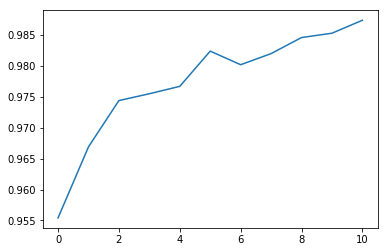

In [14]:
print('Acc: ', trainer_lstm.metrics['valid']['acc'][-1])
plt.plot(trainer_lstm.metrics['valid']['acc']);

## Comparação RNN x LSTM

    - Acurácia RNN: 97,5%
    - Acurácia LSTM: 98,7%

# Exercícios

1. Qual é o número de parâmetros treináveis da rede com solução RNN?
2. Qual é o número de parâmetros para a rede com LSTM?
3. Imprima o dicionário de cada rede e verifique se acertou. 
   Utilize o método `state_dict()` do modelo usado para retornar o dicionário dos pesos.
4. Faça um programa que imprima o número de pesos de cada camada e o número total de pesos.